In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
# import the necessary packages
import os
# define the base path to the input dataset and then use it to derive
# the path to the input images and annotation CSV files

IMAGES_PATH = 'path/'
ANNOTS_PATH = "annotations/"

In [3]:
# define the path to the base output directory
BASE_OUTPUT = "newoutput"
# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.sep.join([BASE_OUTPUT, "detector.h5"])
LB_PATH = os.path.sep.join([BASE_OUTPUT, "label_detection.pkl"])
PLOTS_PATH = os.path.sep.join([BASE_OUTPUT, "plots"])
TEST_PATHS = os.path.sep.join([BASE_OUTPUT, "test_paths.txt"])

In [4]:
# initialize our initial learning rate, number of epochs to train
# for, and the batch size
INIT_LR = 1e-6
NUM_EPOCHS = 40
BATCH_SIZE = 16

In [5]:
# import the necessary packages
from pyimagesearch import config
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

In [6]:
!pip install imutils

In [7]:
# initialize the list of data (images), class labels, target bounding
# box coordinates, and image paths
print("[INFO] loading dataset...")
data = []
labels = []
bboxes = []
imagePaths = []

[INFO] loading dataset...


In [8]:
# loop over all CSV files in the annotations directory
for csvPath in paths.list_files(config.ANNOTS_PATH, validExts=(".csv")):
    print(csvPath)
    # load the contents of the current CSV annotations file
    rows = open(csvPath).read().strip().split("\n")
    
    # loop over the rows
    for row in rows[1:]:
        # break the row into the filename, bounding box coordinates,
        # and class label
        row = row.split(",")
        (filename, startX, startY, endX, endY, label) = row
        # derive the path to the input image, load the image (in
        # OpenCV format), and grab its dimensions
        imagePath = os.path.sep.join([config.IMAGES_PATH,filename])
        
        image = cv2.imread(imagePath)
        if image is not None:
            (h, w) = image.shape[:2]
        # scale the bounding box coordinates relative to the spatial
        # dimensions of the input image
        startX = float(startX) / w
        startY = float(startY) / h
        endX = float(endX) / w
        endY = float(endY) / h
        startX = float(startX) / 4.2
        startY = float(startY) / 3.2
        endX = float(endX) / 4.2
        endY = float(endY) / 3.2
        # load the image and preprocess it
        image = load_img(imagePath, target_size=(300, 300))
        image = img_to_array(image)
        # update our list of data, class labels, bounding boxes, and
        # image paths
        data.append(image)
        labels.append(label)
        bboxes.append((startX, startY, endX, endY))
        imagePaths.append(imagePath)

annotation\acariens.csv
annotation\chancre fusicocum.csv
annotation\coryneum.csv
annotation\faux tigre.csv
annotation\othyorinques.csv
annotation\polystigma.csv
annotation\rouille.csv
annotation\scolytes.csv


In [9]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]

data = np.array(data, dtype="float32") / 255.0

labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")

imagePaths = np.array(imagePaths)
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
    labels = to_categorical(labels)

In [10]:
# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
split = train_test_split(data, labels, bboxes, imagePaths,
    test_size=0.20, random_state=42)



In [11]:
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

In [19]:
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    

In [13]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow import keras
Den = keras.models.load_model('inceptionresnetv2')

In [14]:
Den.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 149, 149, 32) 96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 149, 149, 32) 0           batch_normalization_203[0][0]    
____________________________________________________________________________________________

In [15]:
flatten= Den.get_layer("global_average_pooling2d_1").output

In [16]:
len(lb.classes_)

8

In [20]:
bboxHead = Dense(1000, activation="relu")(flatten)
bboxHead = Dense(500, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid",
    name="bounding_box")(bboxHead)
# construct a second fully-connected layer head, this one to predict
# the class label

softmaxHead = Dense(len(lb.classes_), activation="softmax",
    name="class_label")(flatten)
# put together our model which accept an input image and then output
# bounding box coordinates and a class label
model = Model(
    inputs=Den.input,
    outputs=(bboxHead, softmaxHead))

In [22]:
# define a dictionary to set the loss methods -- categorical
# cross-entropy for the class label head and mean absolute error
# for the bounding box head
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}
# define a dictionary that specifies the weights per loss (both the
# class label and bounding box outputs will receive equal weight)
lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}
# initialize the optimizer, compile the model, and show the model
# summary
opt = Adam(learning_rate=lrfn(40))
model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)


In [23]:
# construct a dictionary for our target training outputs
trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}
# construct a second dictionary, this one for our target testing
# outputs
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [24]:
# train the network for bounding box regression and class label
# prediction
print("[INFO] training model...")
H = model.fit(
    trainImages, trainTargets,
    validation_data=(testImages, testTargets),
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS)


[INFO] training model...
Epoch 1/40
123/123 [==============================] - 111s 743ms/step - loss: 2.1087 - bounding_box_loss: 0.0502 - class_label_loss: 2.0585 - bounding_box_accuracy: 0.5252 - class_label_accuracy: 0.1830 - val_loss: 2.0545 - val_bounding_box_loss: 0.0233 - val_class_label_loss: 2.0313 - val_bounding_box_accuracy: 0.7297 - val_class_label_accuracy: 0.2500
Epoch 2/40
123/123 [==============================] - 87s 707ms/step - loss: 1.9374 - bounding_box_loss: 0.0083 - class_label_loss: 1.9291 - bounding_box_accuracy: 0.6995 - class_label_accuracy: 0.3427 - val_loss: 1.8931 - val_bounding_box_loss: 0.0083 - val_class_label_loss: 1.8848 - val_bounding_box_accuracy: 0.7337 - val_class_label_accuracy: 0.3963
Epoch 3/40
123/123 [==============================] - 89s 725ms/step - loss: 1.7850 - bounding_box_loss: 0.0068 - class_label_loss: 1.7782 - bounding_box_accuracy: 0.6995 - class_label_accuracy: 0.3920 - val_loss: 1.7217 - val_bounding_box_loss: 0.0070 - val_class

In [29]:
# serialize the model to disk

print("[INFO] saving object detector model...")
model.save('newoutput/detector.h5', save_format="h5")
# serialize the label binarizer to disk


[INFO] saving object detector model...


In [30]:
LB_PATH = os.path.sep.join([BASE_OUTPUT, "label_detection.pkl"])
print("[INFO] saving label binarizer...")
# serialize the label binarizer to disk
print("[INFO] saving label binarizer...")
f = open(LB_PATH, "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] saving label binarizer...
[INFO] saving label binarizer...


In [31]:
# plot the total loss, label loss, and bounding box loss
lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
(fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = "Loss for {}".format(l) if l != "loss" else "Total loss"
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l)
    ax[i].plot(N, H.history["val_" + l], label="val_" + l)
    ax[i].legend()
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([PLOTS_PATH, "losses.png"])
plt.savefig(plotPath)
plt.close()

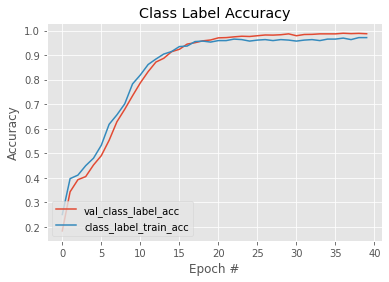

In [26]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
    label="val_class_label_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
    label="class_label_train_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs0.png"])
plt.savefig(plotPath)

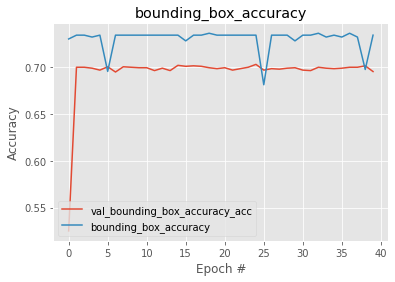

In [27]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["bounding_box_accuracy"],
    label="val_bounding_box_accuracy_acc")
plt.plot(N, H.history["val_bounding_box_accuracy"],
    label="bounding_box_accuracy")
plt.title("bounding_box_accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs1.png"])
plt.savefig(plotPath)

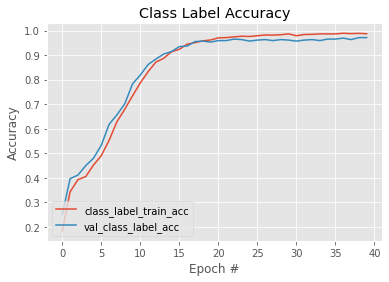

In [28]:
# create a new figure for the accuracies
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["class_label_accuracy"],
    label="class_label_train_acc")
plt.plot(N, H.history["val_class_label_accuracy"],
    label="val_class_label_acc")
plt.title("Class Label Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
# save the accuracies plot
plotPath = os.path.sep.join([PLOTS_PATH, "accs.png"])
plt.savefig(plotPath)